In [5]:
import os

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
import numpy as np
import torch
import sys
import copy
import random
import numpy as np
from collections import defaultdict
from multiprocessing import Process, Queue
import json
import os
import time
from google.colab import drive
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertModel, BertTokenizer

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [10]:
def read_tracks_dataset(dataset_directory):
  tracks_dataset = {}
  for filename in os.listdir(dataset_directory):
      if filename.startswith('tracks_dataset') and filename.endswith('.json'):
          file_path = os.path.join(dataset_directory, filename)
          data = read_json_file(file_path)
          tracks_dataset.update(data)
  return tracks_dataset

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
data_dir = 'drive/My Drive/puc/rec/project/data'

interactions_file = f'{data_dir}/playlistid_itemid_1000p.txt'

idx2name_file = f'{data_dir}/idx2name.json'
uri2idx_file = f'{data_dir}/uri2idx.json'
idx2uri_file = f'{data_dir}/idx2uri.json'

tracks_dataset_directory = f'{data_dir}/tracks_dataset'

In [13]:
idx2name = read_json_file(idx2name_file)
uri2idx = read_json_file(uri2idx_file)
idx2uri = read_json_file(idx2uri_file)

total_tracks = len(uri2idx.keys())
assert total_tracks == len(idx2name.keys())
print(f'Total de tracks: {total_tracks}')

Total de tracks: 34443


In [14]:
tracks_dataset = read_tracks_dataset(tracks_dataset_directory)

In [15]:
print(len(tracks_dataset.keys()))

34404


In [16]:
def get_lyrics(tracks_dataset: dict):
  lyrics_array_shape = [len(uri2idx.keys())]
  lyrics_array = np.full(lyrics_array_shape, '', dtype=object)
  counter = 0
  for idx, uri in enumerate(uri2idx):
    if uri in tracks_dataset:
      track = tracks_dataset[uri]
      if 'lyrics' in track:
        lyrics_array[idx] = track['lyrics']['lyrics_body'].split('\n...\n\n*')[0]
        counter+=1
  print(f'Created lyrics array of {lyrics_array.shape}')
  print(f'Total tracks with lyrics {counter}')
  return lyrics_array

In [17]:
lyrics = get_lyrics(tracks_dataset)

Created lyrics array of (34443,)
Total tracks with lyrics 30233


In [18]:
print(lyrics)

['Uh, Wolf Haley, Golf Wang, go\n\nI\'m a fucking walking paradox\nNo, I\'m not, threesomes with a fucking triceratops\nReptar, rapping as I\'m mocking deaf rock stars\nWearing synthetic wigs made of Anwar\'s dreadlocks\nBedrock, harder than a motherfucking Flintstone\nMaking crack rocks outta pussy nigga fishbones\nThis nigga Jasper trying to get grown\nAbout 5\'7" of his bitches in my bedroom\n\nSwallow the cinnamon, I\'mma scribble this sin and shit\nWhile Syd is telling me that she\'s been getting intimate with men\n(Syd, shut the fuck up) here\'s the number to my therapist\n(Shit) you tell him all your problems, he\'s fucking awesome with listening\n\nUh, Wolf Haley, uh, Golf Wang\nUh, Wolf Haley, Golf fucking Wang\n\nJesus called, he said he\'s sick of the disses\nI told him to quit bitching, this isn\'t a fucking hotline\nFor a fucking shrink, sheesh, I already got mine\nAnd he\'s not fucking working, I think I\'m wasting my damn time\nI\'m clocking three past six and going post

In [19]:
def get_lyrics_len(lyrics):
  return [len(l) for l in lyrics]

lyrics_len = get_lyrics_len(lyrics)

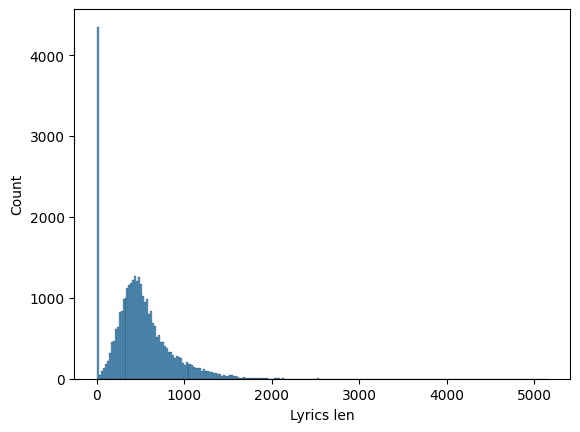

In [20]:
sns.histplot(data=lyrics_len)
plt.xlabel('Lyrics len')
plt.show()

In [21]:
print(lyrics.shape)

(34443,)


In [22]:
model_name = "bert-base-cased"
# model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [23]:
def sentence_to_embedding(sentence, tokenizer=tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    sentence_embedding = last_hidden_states[:, 0, :].squeeze()
    return sentence_embedding.cpu().numpy()

In [24]:
def sentences_to_embedding_matrix(sentences, tokenizer=tokenizer, batch_size = 1024):
    embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_embeddings.cpu().numpy())
    embedding_matrix = np.vstack(embeddings)
    return embedding_matrix

In [25]:
# Tracks names embedding matrix

track_names = np.array(list(idx2name.values()), dtype=object)
print(track_names)
print(track_names.shape)

['Yonkers' 'Lift Your Head Weary Sinner (Chains)' 'Paradise' ...
 'Tally It Up, Settle The Score' 'Saved' 'Boys Like You']
(34443,)


In [26]:
track_names_and_lyrics = []
for n, l in zip(track_names, lyrics):
  track_names_and_lyrics.append(f'{n} {l}')

In [27]:
track_names_embedding_matrix = sentences_to_embedding_matrix(track_names.tolist())
torch.save(track_names_embedding_matrix, f"{data_dir}/track_names_embedding_matrix.pt")

100%|██████████| 34/34 [01:02<00:00,  1.84s/it]


In [28]:
track_lyrics_embedding_matrix = sentences_to_embedding_matrix(lyrics.tolist())
torch.save(track_lyrics_embedding_matrix, f"{data_dir}/track_lyrics_embedding_matrix.pt")

100%|██████████| 34/34 [04:31<00:00,  7.98s/it]


In [29]:
track_names_and_lyrics_embedding_matrix = sentences_to_embedding_matrix(track_names_and_lyrics)
torch.save(track_names_and_lyrics_embedding_matrix, f"{data_dir}/track_names_and_lyrics_embedding_matrix.pt")

100%|██████████| 34/34 [04:30<00:00,  7.95s/it]


In [30]:
def get_genres(tracks_dataset: dict):
  genres_array_shape = [len(uri2idx.keys())]
  genres_array = np.full(genres_array_shape, '', dtype=object)
  counter = 0
  for idx, uri in enumerate(uri2idx):
    if uri in tracks_dataset:
      track = tracks_dataset[uri]
      if 'metadata' in track:
        if len(track['metadata']['genres']['music_genre_list']) > 0:
          genres_array[idx] = track['metadata']['genres']['music_genre_list'][0]['music_genre']['music_genre_name']
        counter+=1
  print(f'Created genres array of {genres_array.shape}')
  print(f'Total tracks with genres {counter}')
  return genres_array

In [31]:
genres = get_genres(tracks_dataset)
print(np.unique(genres).shape)

Created genres array of (34443,)
Total tracks with genres 30235
(184,)


In [32]:
import pandas as pd

tracks_df = pd.DataFrame({'embedding':track_names_embedding_matrix.tolist(), 'track_name':track_names.tolist(), 'genre': genres.tolist()})

In [33]:
tracks_df

,embedding,track_name,genre
0,"[0.5088527798652649, -0.08478257805109024, -0....",Yonkers,Hardcore Rap
1,"[0.3058120012283325, 0.044022656977176666, 0.0...",Lift Your Head Weary Sinner (Chains),Christian & Gospel
2,"[0.17758023738861084, -0.027599947527050972, -...",Paradise,Alternative
3,"[0.3905072808265686, 0.13400468230247498, 0.02...",Nightmare Seeker (The Little Red House),Hard Rock
4,"[-0.007106914184987545, 0.003131106961518526, ...",American Country Love Song,Country
...,...,...,...
34438,"[0.31656408309936523, 0.14151634275913239, -0....",Lay It Down,Rock
34439,"[0.07242363691329956, -0.13304860889911652, -0...",Fallen Angels,Hard Rock
34440,"[0.3338369131088257, -0.1410134881734848, 0.10...","Tally It Up, Settle The Score",Adult Alternative
34441,"[0.44673946499824524, -0.2756352424621582, -0....",Saved,R&B/Soul
